In [27]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
sys.path.append(module_path)

import numpy as np

## Plotting stuff
import matplotlib.pyplot as plt
import matplotlib as mpl
## Default parameters inspired by 
## http://nipunbatra.github.io/2014/08/latexify/
params = {
    'text.latex.preamble': ['\\usepackage{gensymb}'],
    'image.origin': 'lower',
    'image.interpolation': 'nearest',
    'image.cmap': 'magma',
    'axes.grid': False,
#     'savefig.dpi': 150,  # to adjust notebook inline plot size
    'axes.labelsize': 8, # fontsize for x and y labels (was 10)
    'axes.titlesize': 8,
    'font.size': 8, # was 10
    'legend.fontsize': 6, # was 10
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
    'text.usetex': True,
    'figure.figsize': [3.39, 2.10],
    'font.family': 'serif',
    'figure.max_open_warning':10001
}
mpl.rcParams.update(params)
## For colorbar 
from mpl_toolkits.axes_grid1 import make_axes_locatable

## Get physical constants from Scipy
import scipy.constants as con

## For fitting
import scipy.optimize as opt

## For matlab loading
import scipy.io as sio

## Load custom package modules
from misloc_mispol_package.calc import BEM_simulation_wrapper as bem
from misloc_mispol_package.calc import fitting_misLocalization as fit
from misloc_mispol_package.calc import coupled_dipoles as cp
from misloc_mispol_package.optics import diffraction_int as diffi
from misloc_mispol_package.optics import fibonacci as fib

## Some useful numerical constants
hbar = con.physical_constants['Planck constant over 2 pi in eV s'][0]
c = con.physical_constants['speed of light in vacuum'][0]*1e2 #cm/m

m_per_nm = fit.m_per_nm

eps_b = 1.778 ## Water
cm_per_nm = 1E-7

hres_obs_pts = diffi.observation_points(
    -480*m_per_nm, 480*m_per_nm, -480*m_per_nm, 480*m_per_nm, 201)

In [123]:
## Define locations Curly used for simulations. 

x = np.array([
    50, 50, 
    55, 55, 
    60, 60,
    90, 90, 
    140, 140, 
    ])[:,None]

locations =  np.hstack((
    x, 
    np.zeros((x.shape[0], 2))
    )) 
#     + np.array([[0, 0, 1]]) ## Later move particles up to check defocusing effect. 

locations = np.atleast_2d(locations)

## Mol angles should alternate betewee 0 and pi/2 for each loc
mol_angles = np.zeros(locations.shape[0])
for i in range(locations.shape[0]):
    if i % 2 is 1:
        mol_angles[i] = np.pi/2


In [20]:
# locations, angles = just_mols_i_want
sim_inst = bem.SimulatedExperiment(
    locations, 
    mol_angle=mol_angles, 
    obs_points=hres_obs_pts,
    simulation_type='bare_disk_JC'
    )
sim_inst.trial_images = sim_inst.calculate_BEM_fields()

# sim_inst.plot_mispol_map_wMisloc()

starting Matlab...
given even number of points for Fibonacci lattice, 
  adding 1...
1th molecule
calculating diffracted fields


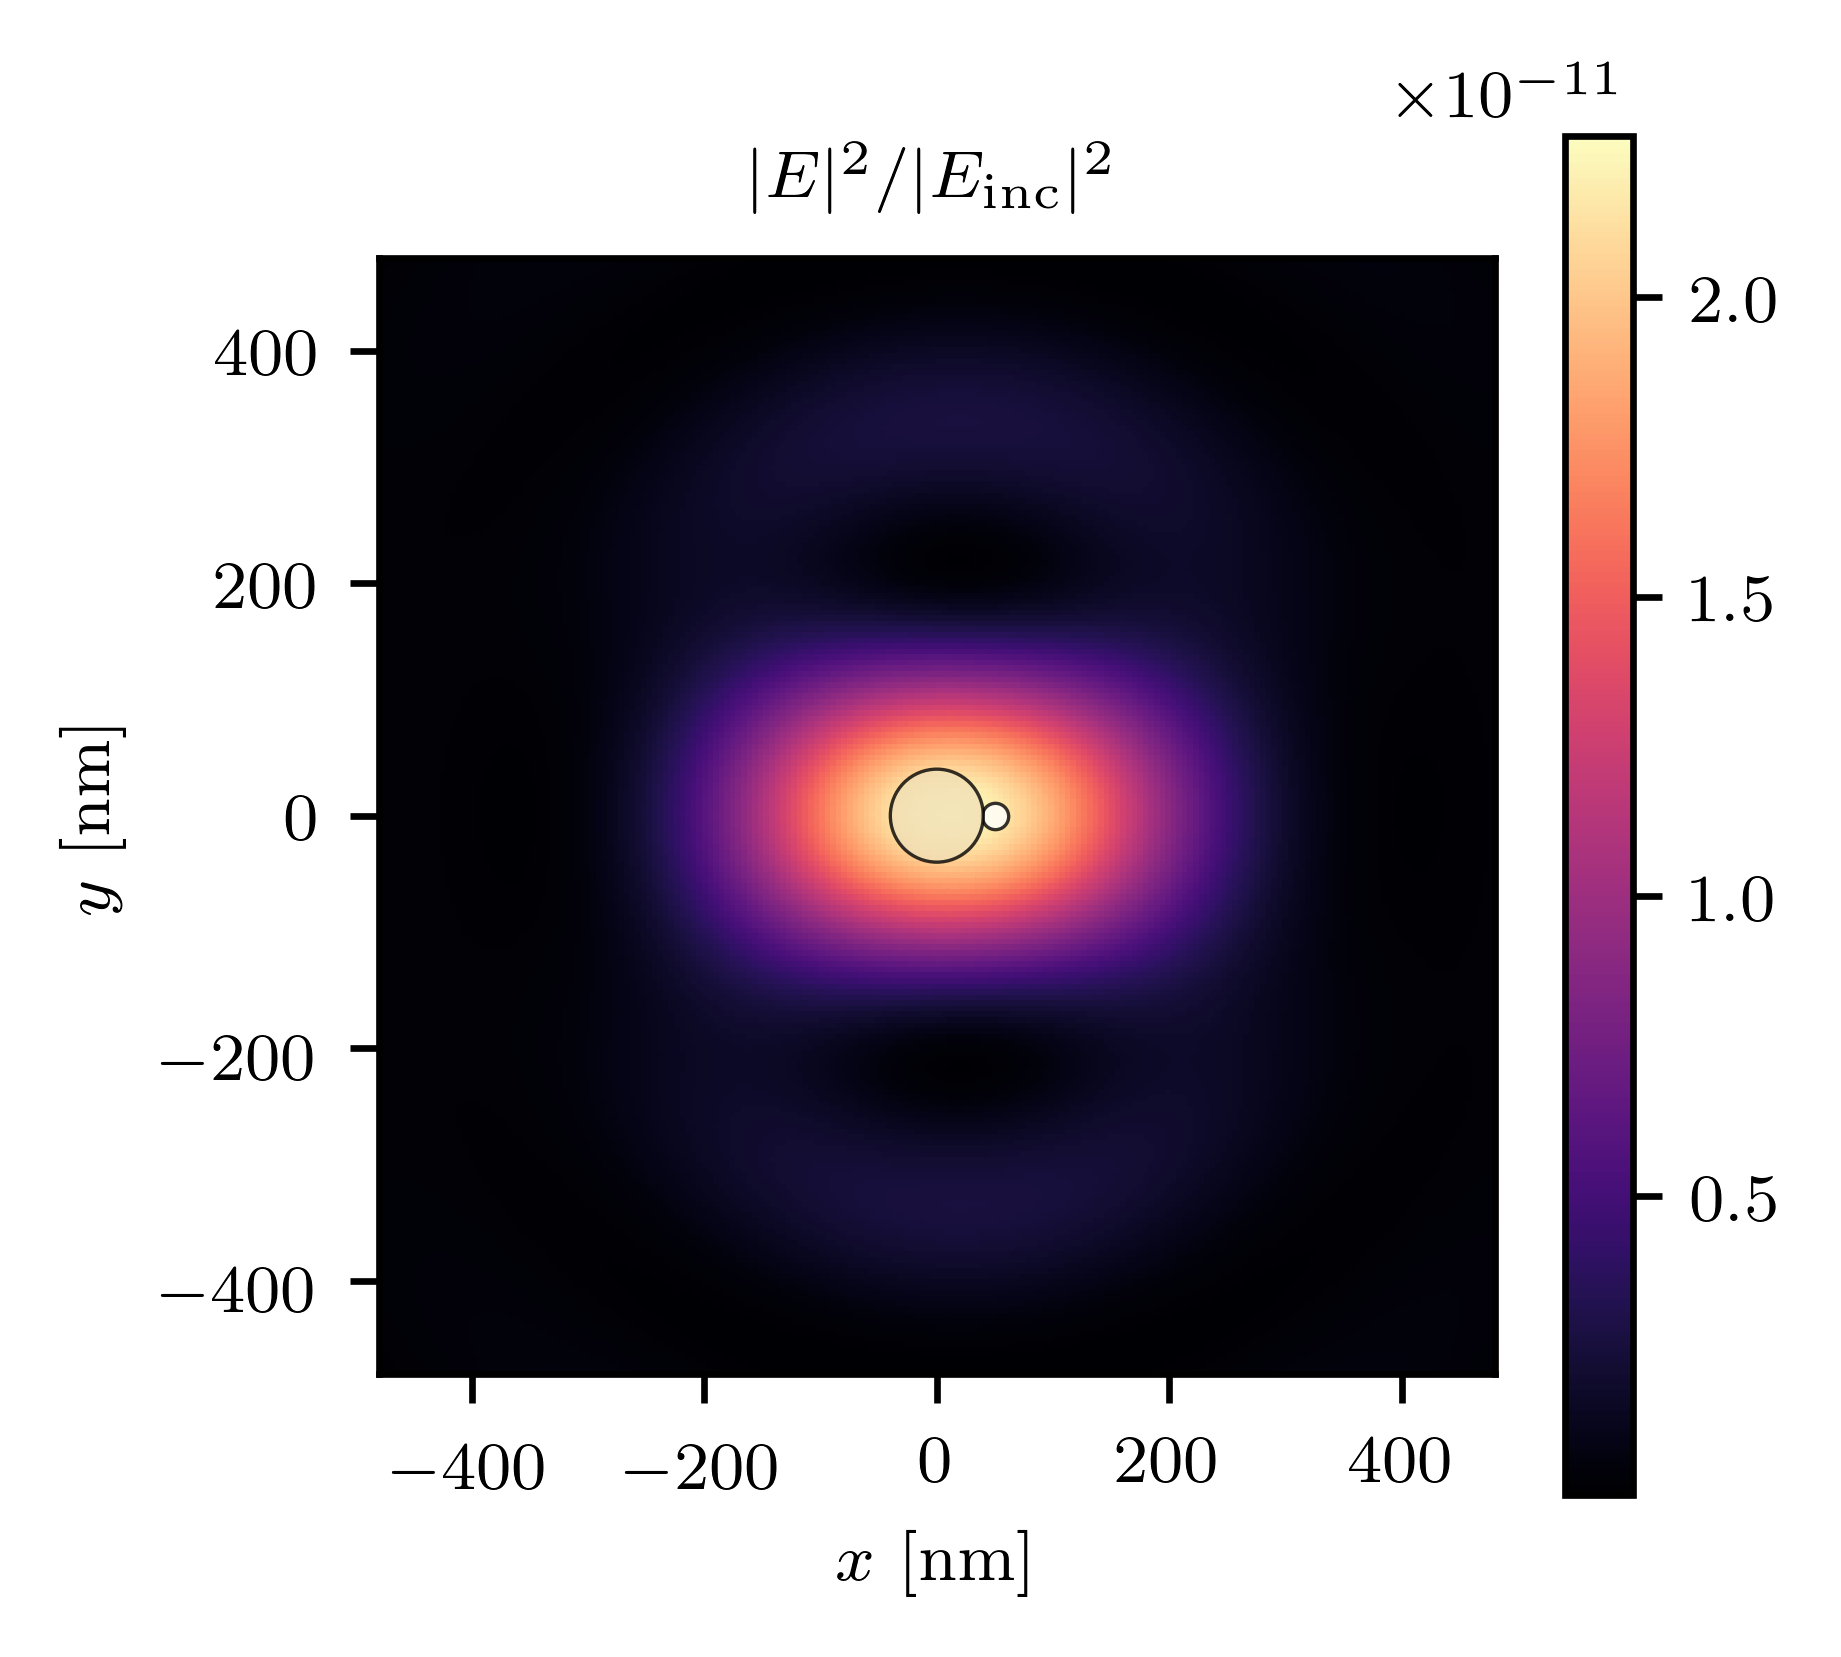

In [26]:
ax = sim_inst.plot_image(0)
ax.set_aspect('equal')

## Draw disk
disk_patch = mpl.patches.Circle(
    (0, 0),
    40,
    # facecolor='Gold',
    facecolor=(241/255, 223/255, 182/255),
    edgecolor='Black',
    linewidth=.4,
     alpha=.8
    )
ax.add_patch(disk_patch)

## scatter mol position
ax.scatter(
    sim_inst.mol_locations[0][0]+0,
    sim_inst.mol_locations[0][1]+0,
    s=10,
    c='w',
    alpha=.8,
    edgecolor='k',
    linewidth=.4
    )

Need a spectrum of the disk in order to parameterize. Will do that now in matlab. 

In [28]:
path_to_spec = os.path.join(
    os.sep,
    'Users',
    'chair',
    'Documents',
    'MATLAB',
    'disk_simulations'
    )

disk_spec = sio.loadmat(os.path.join(
    path_to_spec,
    'bare_disk_spectrum.mat'
    ))

In [31]:
disk_spec.keys()

dict_keys(['__header__', '__version__', '__globals__', 'enei', 'sca'])

In [58]:
hw = 1240/disk_spec['enei'][0]
spec = disk_spec['sca']
spec.shape

(50, 3)

In [59]:
hw.shape

(50,)

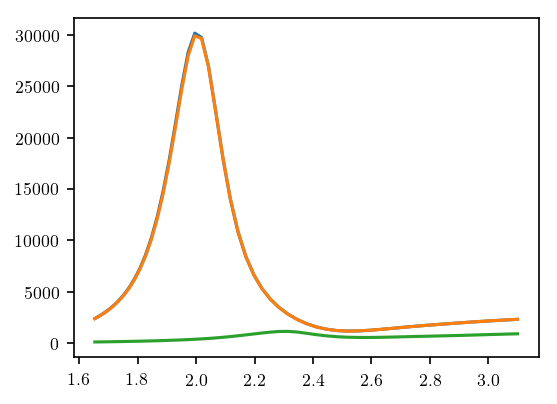

In [61]:
plt.figure(figsize=(4,3), dpi=150)
for i, spectrum in enumerate(spec.T):
    plt.plot(hw, spectrum)

This is a JC spectrum, should do Drude as well for rigor

In [62]:

def ret_fit_scat_1(hbarw, eps_inf, hbarw_p, hbargamma, height, diameter):
    
    a_x = height / 2
    a_yz = diameter / 2
    
    return cp.long_sigma_scat_ret_pro_ellip(
        hbarw/hbar, 
        eps_inf, 
        hbarw_p/hbar, 
        hbargamma/hbar, 
        eps_b, 
        a_x*cm_per_nm, 
        a_yz*cm_per_nm)


In [81]:
#+++++++++++++++++++++++++++++++++++++++++++++
def absol_oblate_cost_f(params, *args):
    x=args[0]
    y=args[1]
    
    ## Parameters
#     eps_inf=params[0]
#     w_p=params[1]
#     gamma=params[2]
#     a_x = params[3]
#     a_yz = params[4]
    
    ## Convert data from nm^2 to cm^2
    y = y*(1e-14) ## cm^2/nm^2
    
    ## Define fit function
    yfit = ret_fit_scat_1(x, *params)

    ## Define scale of cost func for rescaling to order unity 
    cost_scale = 1e-10
    
    return (y-yfit).ravel() / cost_scale



def oblate_fit_result(x, params):
    
    amp = params[-1]
    phys_params = params[:-1]
    
    yfit=ret_fit_scat_1(x, *phys_params)
    
    return yfit/yfit.max() * amp

In [82]:
sigma_scat_data = spec[:,0]

array([12.35045985,  9.28346158,  0.14991186, 40.        , 83.49946839])

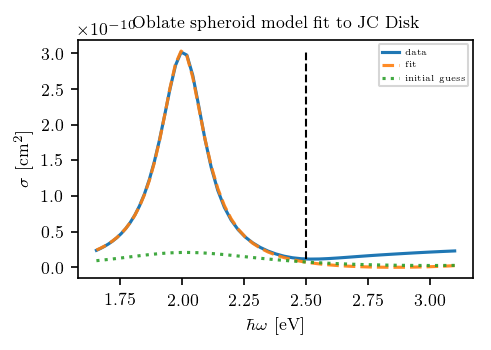

In [125]:
#+++++++++++++++++++++++++++++++++++++++++++++
# ini_guess_params=np.array([3.48260965,  6.72763066,  0.65709936, 29.24119972, 79.24119972])
ini_guess_params=np.array([11.6817827 ,  9.56022562,  0.8554153, 30.24119972, 80.24119972,])
# ini_guess_params=np.array([13.99604932, 10.05123876,  0.28443696, 36.1993746]) 
# ini_guess_params=np.array([15.14244193,  8.4634295 , -0.16462349, 64.3292537 , 28.24427368])
params0=ini_guess_params   #parameter guess

## Reduce fit range
energy_cutoff = 2.5
args=[hw[hw<energy_cutoff], sigma_scat_data[hw<energy_cutoff]]
# for c in Ts:
#   args.append(c) 
args=tuple(args)   #doesn't work if args is a list!!

## Perform minimization of cost function
result=opt.least_squares(
    absol_oblate_cost_f, 
    params0, 
    ftol=1e-15,
    xtol=1e-15, 
    gtol=1e-15, 
    args=args,
    bounds=(
        [0,   0,  0,  30, 70],
        [18, 20, 1,  40, 90],
        ),
    x_scale=[10,10,1E-1,10, 10],
    )
                         
#+++++++++++++++++++++++++++++++++++++++++++++
fit_result = ret_fit_scat_1(hw, *result['x'])
ini_guess = ret_fit_scat_1(hw, *ini_guess_params)


## Build figure
plt.figure(dpi=150)

## Plot Data
plt.plot(hw, sigma_scat_data*1E-14, label='data')
plt.plot(
    [2.5, 2.5],
    [np.min(sigma_scat_data*1E-14), np.max(sigma_scat_data*1E-14)],
    ls='dashed',
    c='k',
    lw=1)

## Plot best fit
plt.plot(
    hw, 
    fit_result, 
    label='fit',
    ls='--', 
#     marker='.', 
    markersize=1, 
    alpha=.9)

## Plot initial guess
plt.plot(
    hw, 
    ini_guess, 
    label='initial guess',
    ls='dotted', 
#     marker='.', 
    markersize=1, 
    alpha=.9)

plt.xlabel(r'$\hbar\omega$ [eV]')
# plt.xlim([1.4, 2.7])
plt.ylabel(r'$\sigma$ [cm$^2$]')
plt.title(r'Oblate spheroid model fit to JC Disk')
plt.legend(fontsize=4)

result['x']

In [85]:
result

 active_mask: array([0, 0, 0, 1, 0])
        cost: 0.003852572475068333
         fun: array([ 0.03677396,  0.02641295,  0.01954642,  0.0155293 ,  0.01254973,
        0.00949653,  0.00532587, -0.00078105, -0.00855619, -0.01704092,
       -0.02421387, -0.02643646, -0.01934708, -0.0017948 ,  0.01944247,
        0.02735457,  0.00998276, -0.01423657, -0.0213616 , -0.01203039,
        0.00169573,  0.01121331,  0.0144152 ,  0.01267373,  0.00903856,
        0.00547792,  0.00259821,  0.00046933, -0.00101302, -0.00198909,
       -0.00262962, -0.00309301, -0.00346479, -0.00378862, -0.00408615,
       -0.00436761])
        grad: array([-2.65712029e-10,  6.92656529e-10,  5.54633847e-08, -4.30586449e-06,
        3.82596893e-10])
         jac: array([[ 7.35171049e-02, -2.04573544e-01,  1.77572821e-02,
        -3.73065567e-03, -2.86644278e-03],
       [ 8.83403548e-02, -2.52344233e-01,  3.84272789e-02,
        -4.85833231e-03, -3.41290924e-03],
       [ 1.06285458e-01, -3.11533729e-01,  6.79711290e-02

Things that would be interesting to compare, 
- How does fitting just long axis compare to simultaneous fit of long and short axis, like in the rod case
    - this could be a significant difference between the rod and disk situations that I had not previously acknowledged. 
    - If I do not constrain the fit to the long axis the radii tend to equalize. 

Should also maybe check z orientation?